In [2]:
import time
import warnings

import numpy as np
import numpy.linalg as LA
import scipy.linalg as SLA
from scipy import io
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import layers
from scipy.stats import ortho_group

# Customized RNN cells #
We use RNN cells as discrete models for a system of ODEs
$$ \dot{z}=Wz+Rf(x) $$
$$ \dot{x}=R^Tz $$
Assume $f(x)=-\nabla E(x)$ for some energy functional $E(x)$. The ODE system is stable if $W^T+W \preceq 0$.

## Constant matrices ## 
1. Forward Euler Discrete Model
$$ z_{i+1} = (I+W_d) z_i + \frac{1}{c}R_df(x_i) $$
$$ x_{i+1} = x_i + kR_d^Tz_i $$
2. The second model we try can be considered as a implicit mid-point discretization but with local linearization of $f$.
$$ z_{i+1} = z_i + W_d \frac{z_i+z_{i+1}}{2} + \frac{1}{c}R[f(x_i)+J_f(x_i)\frac{x_{i+1}-x_i}{2}] $$
$$ x_{i+1} = x_i + kR^T\frac{z_i+z_{i+1}}{2} $$
If $f$ is a linear force (i.e., $E(x)$ is quadratic), this model is guaranteed to be globally asymptotically stable (G.A.S.) if $W_d+W^T_d\preceq 0$ because it is the backward Euler scheme of a stable ODE with a quadratic lyapunov functional.  
If $f$ is not linear, then $W_d+W^T_d\preceq 0$ can only guarantee local stability.  
A direct way of enforcing $W_d+W^T_d\preceq 0$ is to decompose $W_d$ into a symmetric matrix and a skew-symmetric matrix. It follows that $W_d$ is similar to the sum of a diagonal matrix of nonpositive diagonal entries and a skew-symmetric matrix
$$ W_d\sim D_d+S_d, \quad D_d\preceq 0, \quad S_d=-S_d^T. $$

In [3]:
class Between(keras.constraints.Constraint):
    def __init__(self, min_value, max_value):
        self.min_value = min_value
        self.max_value = max_value

    def __call__(self, w):        
        return K.clip(w, self.min_value, self.max_value)

    def get_config(self):
        return {'min_value': self.min_value,
                'max_value': self.max_value}
    
class rnn_const_exp(layers.Layer):
    def __init__(self, dimx, dimz, c, k, force):
        super(rnn_const_exp, self).__init__()
        self.c = c
        self.k = k
        self.dimx = dimx
        self.units = dimz
        self.state_size = (self.units, self.dimx)
        self.F = force # force function
        
    def build(self, input_shapes):
        # R's entries are likely to be small
        self.R = self.add_weight(
            shape=(self.dimx, self.units), initializer=keras.initializers.Orthogonal(), name="fsi_coupling"
        )
        
        self.nd = self.add_weight(
            shape=(self.units,), initializer=keras.initializers.Constant(value=.5), 
            constraint=Between(0.0, 2.0),
            name="hidden_opt"
        )
        
        self.A = self.add_weight(
            shape=(self.units,self.units), initializer=keras.initializers.Constant(value=0.), 
            name="ssym"
        )
        
        self.built = True
        
    def call(self, inputs, states):
        # states[0] = z_i, state[1]=x_i-x_0 (agrees with 0 initial state)
        # inputs are all x0
        # outputs are x1,x2,...,xN
        zi = states[0]
        xi = inputs+states[1]
        F = 1/self.c * self.F(xi)
        zip1 = F @ self.R + zi * (1-self.nd) + zi @ self.A - zi @ tf.transpose(self.A)
        dx = zi @ tf.transpose(self.R)
        return dx, [zip1, states[1]+self.k*dx]

In [4]:
class rnn_const_exp(layers.Layer):
    def __init__(self, dimx, dimz, c, k, force):
        super(rnn_const_exp, self).__init__()
        self.c = c
        self.k = k
        self.dimx = dimx
        self.units = dimz
        self.state_size = (self.units, self.dimx)
        self.F = force # force function
        
    def build(self, input_shapes):
        # R's entries are likely to be small
        self.R = self.add_weight(
            shape=(self.dimx, self.units), initializer=keras.initializers.Orthogonal(), name="fsi_coupling"
        )
        
        self.nd = self.add_weight(
            shape=(self.units,), initializer=keras.initializers.Constant(value=.5), 
            name="hidden_opt"
        )
        
        self.built = True
        
    def call(self, inputs, states):
        # states[0] = z_i, state[1]=x_i-x_0 (agrees with 0 initial state)
        # inputs are all x0
        # outputs are x1,x2,...,xN
        zi = states[0]
        xi = inputs+states[1]
        F = 1/self.c * self.F(xi)
        zip1 = F @ self.R + zi * self.nd
        dx = zi @ tf.transpose(self.R)
        return dx, [zip1, states[1]+self.k*dx]

In [5]:
class rnn_const_mid(layers.Layer):
    # current version has diagonal -1<-D<0
    def __init__(self, dimx, dimz, c, k, force, jf):
        super(rnn_const_mid, self).__init__()
        self.c = c
        self.k = k
        self.dimx = dimx
        self.units = dimz
        self.state_size = (self.units, self.dimx)
        self.F = force # force function
        self.Jf = jf # jacobian of the force, also a function of x
        
    def build(self, input_shapes):
        # R's entries are likely to be small
        self.R = self.add_weight(
            shape=(self.dimx, self.units), initializer=keras.initializers.Orthogonal(), name="fsi_coupling"
        )
        # W is supposed to be a small perturbation of the identity matrix
        self.nd = self.add_weight(
            shape=(self.units,), initializer=keras.initializers.Constant(value=0.1), 
            constraint=keras.constraints.NonNeg(), name="hidden_opt"
        )
        #self.A = self.add_weight(
        #    shape=(self.units,self.units), initializer=keras.initializers.Constant(value=0.), 
        #    name="ssym"
        #)
        self.built = True
        
    def call(self, inputs, states):
        # states[0] = z_i, state[1]=x_i-x_0 (agrees with 0 initial state)
        # inputs are all x0
        # outputs are x1,x2,...,xN
        zi = states[0]
        xi = inputs+states[1]
        J = self.Jf(xi)
        F = 1/self.c*self.F(xi)
        #S = tf.linalg.inv(tf.linalg.diag(1+0.5*self.nd)+self.A-tf.transpose(self.A)
        #                  -0.25*self.k/self.c*tf.transpose(self.R) @ tf.transpose(J) @ self.R)
        S = tf.linalg.inv(tf.linalg.diag(1+0.5*self.nd)
                          -0.25*self.k/self.c*tf.transpose(self.R) @ tf.transpose(J) @ self.R)
        zip1 = (2*zi + F @ self.R) @ S - zi
        dx = 0.5*(zi+zip1) @ tf.transpose(self.R)
        return dx, [zip1, states[1]+self.k*dx]

In [6]:
class rnn_const_mid_us(layers.Layer):
    # current version has diagonal -1<-D<0
    def __init__(self, dimx, dimz, c, k, force, jf):
        super(rnn_const_mid_us, self).__init__()
        self.c = c
        self.k = k
        self.dimx = dimx
        self.units = dimz
        self.state_size = (self.units, self.dimx)
        self.F = force # force function
        self.Jf = jf # jacobian of the force, also a function of x
        
    def build(self, input_shapes):
        # R's entries are likely to be small
        self.R = self.add_weight(
            shape=(self.dimx, self.units), initializer=keras.initializers.Orthogonal(), name="fsi_coupling"
        )
        # W is not necessarily (W+W^T<0)
        self.W = self.add_weight(
            shape=(self.units, self.units), 
            initializer=keras.initializers.Constant(value=0.1),
            name="hidden_opt"
        )
        self.built = True
        
    def call(self, inputs, states):
        # states[0] = z_i, state[1]=x_i-x_0 (agrees with 0 initial state)
        # inputs are all x0
        # outputs are x1,x2,...,xN
        zi = states[0]
        xi = inputs+states[1]
        J = self.Jf(xi)
        F = 1/self.c*self.F(xi)
        S = tf.linalg.inv(tf.eye(self.units)+self.W-0.25*self.k/self.c*tf.transpose(self.R) @ tf.transpose(J) @ self.R)
        zip1 = (2*zi + F @ self.R) @ S - zi
        dx = 0.5*(zi+zip1) @ tf.transpose(self.R)
        return dx, [zip1, states[1]+self.k*dx]

# Build Models #

In [7]:
def build_const_exp_model(x_dim, hidden_dim, time_steps, c, k, force_func):
    # input is (batch_size, time_steps, x0s)
    rnn_cell = rnn_const_exp(x_dim, hidden_dim, c, k, force_func)
    rnn = layers.RNN(rnn_cell, return_sequences=True)
    inputs = keras.Input(shape=(time_steps, x_dim))
    outputs = rnn(inputs)
    model = keras.Model(inputs=inputs, outputs=outputs, name="const_exp_rom")
    return model

In [8]:
def build_const_mid_model(x_dim, hidden_dim, time_steps, c, k, force_func, jf):
    # input is (batch_size, time_steps, x0s)
    rnn_cell = rnn_const_mid(x_dim, hidden_dim, c, k, force_func, jf)
    rnn = layers.RNN(rnn_cell, return_sequences=True)
    inputs = keras.Input(shape=(time_steps, x_dim))
    outputs = rnn(inputs)
    model = keras.Model(inputs=inputs, outputs=outputs, name="const_mid_rom")
    return model

In [9]:
def build_const_mid_model_us(x_dim, hidden_dim, time_steps, c, k, force_func, jf):
    # input is (batch_size, time_steps, x0s)
    rnn_cell = rnn_const_mid_us(x_dim, hidden_dim, c, k, force_func, jf)
    rnn = layers.RNN(rnn_cell, return_sequences=True)
    inputs = keras.Input(shape=(time_steps, x_dim))
    outputs = rnn(inputs)
    model = keras.Model(inputs=inputs, outputs=outputs, name="const_mid_rom")
    return model

# Data Preparation #
Raw data is a matlab file with x0, x1, ..., xn and f(x0), f(x1), ..., f(xn). We specify if we are learning a single sequence. The sequences might be long, a cutoff length can be provided to train (validate) only on the first few time steps. Note that this does not apply to test data since we do want to test long term behavior. 
1. When True, only the first sequence in raw data is processed, and batch_size is 1. It serves as both training and testing data. 
2. When False, the data is split into train/validation/test set.

In [10]:
# load data. Size must follow
# input(xdata): (number of samples, time steps, input dimension)
# output(ydata): (number of samples, time steps, output dimension)
def load_matlab(filepath):
    matlab_data = io.loadmat(filepath)
    input_matlab = matlab_data['fs'] # 1-by-N array N=number of sequences
    output_matlab = matlab_data['xs'] # 1-by-N array
    
    #assert input_matlab.shape[1] == output_matlab.shape[1], 'number of samples must be consistent in input and output'
    input_matlab = input_matlab[0] # 1D np array of length N, each has dimension (ts, dimx)
    output_matlab = output_matlab[0]
    
    fdata = np.empty((input_matlab.shape[0], input_matlab[0].shape[0], input_matlab[0].shape[1]))
    xdata = np.empty((output_matlab.shape[0], output_matlab[0].shape[0], output_matlab[0].shape[1]))
    for i in range(xdata.shape[0]):
        if i<fdata.shape[0]:
            fdata[i] = input_matlab[i] # forces
        xdata[i] = output_matlab[i] # xs
    # compute the scalar that normalizes f
    mag_dx = abs(xdata[:,1:,:]-xdata[:,:-1,:]).max()
    mag_f = abs(fdata).max()
    print(f'force magnitude: {mag_f:02f}')
    print(f'dx magnitude: {mag_dx:02f}')
    return xdata, mag_f, mag_dx, fdata

In [11]:
def data_loader(xs, mag_dx, one_seq=True, cutoff=None, batch_size=32, val_ratio=0.3, test_ratio=0.2):
    
    # check there's enough (50%) training data left
    assert val_ratio + test_ratio <= 0.5, 'Please use less data for validation and test.'
    
    if cutoff is None:
        cutoff = xs.shape[1]-1 # data include step 0 ~ step n, model only outputs step 1 ~ step n
    cutoff = min(cutoff, xs.shape[1]-1)
    
    if one_seq:
        xdata = xs[0] # (ts, dimx) array
        x0 = xdata[0]
        x0s = np.array([np.tile(x0, (cutoff, 1))])
        #xs = np.array([xdata[1:cutoff+1]])
        xs = 1/mag_dx*np.array([xdata[1:cutoff+1]-xdata[:cutoff]]) # output is scaled dx
        train_dataset = tf.data.Dataset.from_tensor_slices((x0s, xs)).batch(1)
        return train_dataset, cutoff, np.array([xdata])
    
    # shuffle data
    shuffler = np.random.permutation(len(xs))
    xs = xs[shuffler]
    
    nos = xs.shape[0] # number of samples
    test_size = int(nos * test_ratio)
    val_size = int(nos * val_ratio)
    
    x_test = xs[-test_size:]
    
    x_val = xs[-test_size-val_size:-test_size]
    x0_val = np.empty((x_val.shape[0], cutoff, x_val.shape[2]))
    for i in range(x0_val.shape[0]):
        x0_val[i] = np.tile(x_val[i,0,:], (cutoff, 1))
    
    x_train = xs[:-test_size-val_size]
    x0_train = np.empty((x_train.shape[0], cutoff, x_train.shape[2]))
    for i in range(x0_train.shape[0]):
        x0_train[i] = np.tile(x_train[i,0,:], (cutoff, 1))
    
    # Prepare the training dataset.
    train_dataset = tf.data.Dataset.from_tensor_slices((x0_train, 1/mag_dx*(x_train[:,1:cutoff+1,:]-x_train[:,:cutoff,:])))
    train_dataset = train_dataset.shuffle(buffer_size=min(1024, x0_train.shape[0])).batch(batch_size)

    # Prepare the validation dataset.
    val_dataset = tf.data.Dataset.from_tensor_slices((x0_val, 1/mag_dx*(x_val[:,1:cutoff+1,:]-x_val[:,:cutoff,:])))
    val_dataset = val_dataset.batch(batch_size)
    
    return train_dataset, val_dataset, cutoff, x_test

# Test Routine #
The test data is an array of shape (samples, timesteps, dimx). We randomly choose a sample (of x at time step 0 only). Use the model weights to generate an arbitrarily long sequence. The function then
1. plots the 0 component of the data and the generated sequence
2. computes the loss up to length of the test data.

In [12]:
def lsim(x0, n_step, rnncell):
    h = tf.zeros((1,rnncell.units))
    dx0 = tf.zeros(rnncell.dimx)
    inputs = tf.convert_to_tensor([x0], dtype=tf.float32)
    state = [h, dx0]
    #xs_p = [x0]
    xs_p = []
    for _ in range(n_step):
        x, state = rnncell.call(inputs, state)
        xs_p.append(x.numpy().reshape(x0.shape[0],))
    #return np.array(xs_p) # shape (n_step+1, dimx) 
    return rnncell.k*np.array(xs_p) # shape (n_step, dimx) 

In [13]:
def test_traj_plot(cus_model, x_true, n_step=None, randsample=False, randcomp=False):
    # x_true has shape (samples, ts, dimx)
    if randsample:
        sample_id = np.random.randint(x_true.shape[0])
    else:
        sample_id = 0
    xdata = x_true[sample_id]
    x0 = xdata[0]
    if n_step is None:
        n_step = xdata.shape[0]-1
    comp_id = 0
    if randcomp:
        comp_id = np.random.randint(x_true.shape[2])
    rnncell = cus_model.layers[1].cell
    #x_pred = lsim(x0, n_step, rnncell)
    dx = lsim(x0, n_step, rnncell)
    x_pred = np.vstack((x0, np.cumsum(dx, axis=0)+x0))
    plt.plot(xdata[:,comp_id], label='true')
    plt.plot(x_pred[:,comp_id], '--', label='pred')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(prop={'size': 16})
    plt.xlabel('time steps', fontsize=18)
    plt.ylabel('x', fontsize=18)
    #plt.title(f"Sample ID: {sample_id} Test Trajectory of component {comp_id}", fontsize=18)
    
    #compute test loss
    ts = min(n_step, xdata.shape[0]-1)+1
    #print(f"Test loss of sample {sample_id}: {(np.square(xdata[:ts] - x_pred[:ts])).mean():.6f}.")
    print(f"Test loss of sample {sample_id}: {(np.square(1/rnncell.k*(xdata[1:ts]-xdata[:ts-1]-dx[:ts-1]))).mean():.6f}.")
    return x_pred, xdata

# Examples #
We currently have 4 datasets with full-order models:  
1.1 Data generated by SISO linear model.  
1.2 Data generated by MIMO linear model.  
2.1 FSI rubberband with linear spring force.  
2.2 FSI rubberband with nonlinear spring force.  

The first two data sets are fed in batches, while the two rubberband data sets are trained using only one sequence.

## Define global loss function and metrics ##

In [14]:
# Instantiate a loss function.
loss_fn = keras.losses.MeanSquaredError()

# Prepare the metrics.
train_acc_metric = keras.metrics.MeanSquaredError()
val_acc_metric = keras.metrics.MeanSquaredError()

## Define training routines ##

In [15]:
def train_fcns(model, lr):
    # Instantiate an optimizer.
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    # define training and validation functions
    @tf.function
    def train_step(x, y):
        with tf.GradientTape() as tape:
            yout = model(x, training=True)
            loss_value = loss_fn(y, yout)
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        train_acc_metric.update_state(y, yout)
        return loss_value 

    # The tf.function decorator accelerate tensor computation by graph computing 
    @tf.function
    def val_step(x, y):
        val_out = model(x, training=False)
        val_acc_metric.update_state(y, val_out)
    return train_step, val_step

In [16]:
def train_loop(epochs, train_step, val_step):
    neprint = 20
    errs = []
    for epoch in range(epochs):
        start_time = time.time()
        # Iterate over the batches of the dataset.
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            loss_value = train_step(x_batch_train, y_batch_train)
            errs.append(float(loss_value))
            

        # Display metrics at the end of each epoch.
        train_acc = train_acc_metric.result()
        # Reset training metrics at the end of each epoch
        train_acc_metric.reset_states()
        # Run a validation loop at the end of each epoch.
        for x_batch_val, y_batch_val in val_dataset:
            val_step(x_batch_val, y_batch_val)

        val_acc = val_acc_metric.result()
        val_acc_metric.reset_states()
        if (epoch+1) % neprint==0:
            print(f"Training acc over epoch: {float(train_acc):.6f}")
            print("Validation acc: %.4f" % (float(val_acc),))
            print("Time taken: %.2fs" % (time.time() - start_time))
    return errs

## Example 1.1: SISO Linear ##

In [17]:
filepath = '../matlab/eady_fb_siso.mat'
xdata, c, k, fdata = load_matlab(filepath)
train_dataset, val_dataset, ts, siso_test = data_loader(xdata, k, one_seq=False, cutoff=15, batch_size=8, val_ratio=0.2, test_ratio=0.1)

force magnitude: 0.976196
dx magnitude: 0.230573


In [18]:
# force function (linear for this example)
def fsiso(x):
    '''
    x is a tensor with shape = (batch, dimx)
    '''
    return -x

### 1. Explicit Model ###

In [17]:
#build model
x_dim = siso_test.shape[2]
time_steps = ts

# specify hidden dimension
hidden_dim = 10

# build linear model
exp_siso = build_const_exp_model(x_dim, hidden_dim, time_steps, c, k, fsiso)
exp_siso.summary()

Model: "const_exp_rom"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15, 1)]           0         
_________________________________________________________________
rnn (RNN)                    (None, 15, 1)             20        
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________


In [111]:
train_step, val_step = train_fcns(exp_siso, 1e-1)

In [113]:
_ = train_loop(100, train_step, val_step)

Training acc over epoch: 0.078521
Validation acc: 0.0495
Time taken: 0.04s
Training acc over epoch: 0.071590
Validation acc: 0.0451
Time taken: 0.03s
Training acc over epoch: 0.064355
Validation acc: 0.0405
Time taken: 0.03s
Training acc over epoch: 0.045195
Validation acc: 0.0278
Time taken: 0.03s
Training acc over epoch: 0.001061
Validation acc: 0.0007
Time taken: 0.03s


In [18]:
exp_siso.load_weights('model_weights/exp_siso_unstable.h5')

Test loss of sample 0: 0.570120.


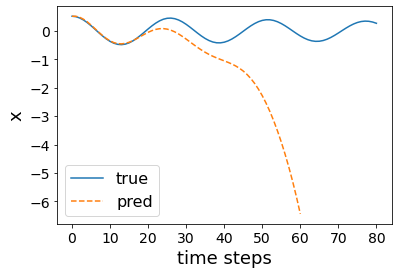

In [19]:
#test
x_pred_us, siso_test_exp = test_traj_plot(exp_siso, siso_test, n_step=60)
#plt.savefig('../Notes/siso_unstable.png')

In [20]:
x_pred_us.shape

(61, 1)

In [21]:
siso_test_exp.shape

(81, 1)

In [22]:
np.save('data/siso_test_exp.npy', siso_test_exp)
np.save('data/siso_exp_us.npy', x_pred_us)

In [108]:
exp_siso.save_weights('model_weights/exp_siso_unstable.h5')

In [118]:
cell_exp_siso = exp_siso.layers[1].cell
M_d = np.vstack((np.hstack((np.diag(1.0-cell_exp_siso.nd.numpy())+cell_exp_siso.A.numpy().T-cell_exp_siso.A.numpy(), 
                            -cell_exp_siso.R.numpy().T)),
           np.hstack((cell_exp_siso.R.numpy(), [[1]]))))
w, v = LA.eig(M_d)
min(w.real)

-0.774606875849288

### 2. Implicit Model ###

In [19]:
# Implicit model requires the force Jacobian
def jfsiso(x):
    '''
    x is a tensor with shape = (batch, dimx). 
    When batch > 1, this must return a constant matrix, i.e., the force is linear.
    '''
    return -tf.eye(x.shape[-1])

In [20]:
#build model
x_dim = siso_test.shape[2]
time_steps = ts

# specify hidden dimension
hidden_dim = 10

# build linear model
mid_siso = build_const_mid_model(x_dim, hidden_dim, time_steps, c, k, fsiso, jfsiso)
mid_siso.summary()

Model: "const_mid_rom"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15, 1)]           0         
_________________________________________________________________
rnn (RNN)                    (None, 15, 1)             20        
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________


In [25]:
mid_siso.load_weights('model_weights/mid_siso_stable15.h5')

In [60]:
#build unstable (more accurately, not sure if stable) model
x_dim = siso_test.shape[2]
time_steps = ts

# specify hidden dimension
hidden_dim = 10

# build linear model
mid_siso_us = build_const_mid_model_us(x_dim, hidden_dim, time_steps, c, k, fsiso, jfsiso)
mid_siso_us.summary()

Model: "const_mid_rom"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 15, 1)]           0         
_________________________________________________________________
rnn_3 (RNN)                  (None, 15, 1)             110       
Total params: 110
Trainable params: 110
Non-trainable params: 0
_________________________________________________________________


In [21]:
train_step, val_step = train_fcns(mid_siso, 1e-2)

In [22]:
errs = train_loop(100, train_step, val_step)

Training acc over epoch: 0.000633
Validation acc: 0.0006
Time taken: 0.03s
Training acc over epoch: 0.000038
Validation acc: 0.0000
Time taken: 0.04s
Training acc over epoch: 0.000007
Validation acc: 0.0000
Time taken: 0.03s
Training acc over epoch: 0.000004
Validation acc: 0.0000
Time taken: 0.04s
Training acc over epoch: 0.000004
Validation acc: 0.0000
Time taken: 0.02s


In [28]:
np.save('data/err_stable.npy', np.array(errs))

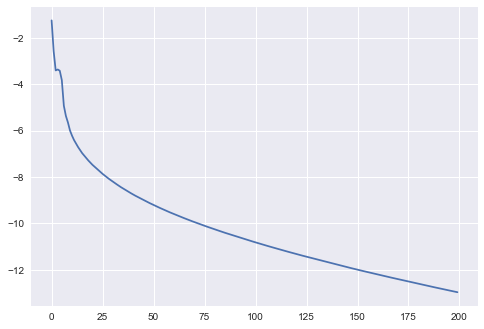

In [25]:
plt.plot(np.log(errs))

Test loss of sample 0: 0.000258.


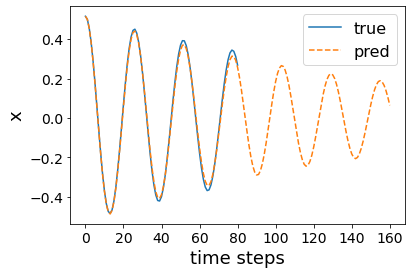

In [26]:
#test
x_pred_mids, siso_test_mids = test_traj_plot(mid_siso, siso_test, n_step=160)
#plt.savefig('../Notes/siso_mid_unstable.png')

In [64]:
np.save('data/siso_mid_us.npy', x_pred_midus)

In [72]:
np.save('data/siso_mid_s.npy', x_pred_mids)
np.save('data/siso_mid_s.npy', x_pred_mids)

In [65]:
mid_siso_us.save_weights('model_weights/mid_siso_unstable.h5')

In [35]:
w = -mid_siso_us.layers[1].cell.W.numpy()
r = mid_siso_us.layers[1].cell.R.numpy()
M_d = np.vstack((np.hstack((w.T, r.T)),
           np.hstack((r, [[1]]))))
evals, _ = LA.eig(M_d)
max(abs(evals))

1.250615254415248

In [155]:
mid_siso.save_weights('model_weights/mid_siso_stable15.h5')

## Example 1.2: MIMO Linear ##

In [73]:
# load data
filepath = '../matlab/eady_fb_mimo.mat'
xdata, c, k, fdata = load_matlab(filepath)
train_dataset, val_dataset, ts, mimo_test = data_loader(xdata, k, cutoff=15, one_seq=False, batch_size=8, val_ratio=0.2, test_ratio=0.1)

force magnitude: 1.360832
dx magnitude: 0.239935


In [74]:
# force function (linear for this example, same as SISO)
def fmimo(x):
    '''
    x is a tensor with shape = (batch, dimx)
    '''
    return -x

### 1. Explicit Model ###

In [17]:
mimo_test.shape

(10, 81, 16)

In [18]:
xdata.shape

(100, 81, 16)

In [29]:
#build model
x_dim = mimo_test.shape[2]
time_steps = ts

# specify hidden dimension
hidden_dim = x_dim*2

# build linear model
exp_mimo = build_const_exp_model(x_dim, hidden_dim, time_steps, c, k, fmimo)
exp_mimo.summary()

Model: "const_exp_rom"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 80, 16)]          0         
_________________________________________________________________
rnn_2 (RNN)                  (None, 80, 16)            544       
Total params: 544
Trainable params: 544
Non-trainable params: 0
_________________________________________________________________


In [30]:
train_step, val_step = train_fcns(exp_mimo, 1e-2)

In [31]:
train_loop(100, train_step, val_step)

Training acc over epoch: 0.002261
Validation acc: 0.0026
Time taken: 0.04s
Training acc over epoch: 0.001241
Validation acc: 0.0017
Time taken: 0.05s
Training acc over epoch: 0.000744
Validation acc: 0.0012
Time taken: 0.04s
Training acc over epoch: 0.000536
Validation acc: 0.0009
Time taken: 0.04s
Training acc over epoch: 0.000375
Validation acc: 0.0008
Time taken: 0.05s


Test loss of sample 1: 0.00.


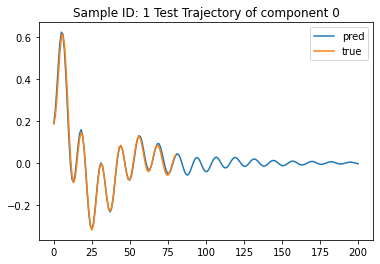

In [32]:
#test
_ = test_traj_plot(exp_mimo, mimo_test, n_step=200)

### Implicit Model ###

In [75]:
# Implicit model requires the force Jacobian, in this example it's -I
def jfmimo(x):
    '''
    x is a tensor with shape = (batch, dimx). 
    When batch > 1, this must return a constant matrix, i.e., the force is linear.
    '''
    return -tf.eye(x.shape[-1])

In [76]:
#build model
x_dim = mimo_test.shape[2]
time_steps = ts

# specify hidden dimension
hidden_dim = 2*x_dim

# build linear model
mid_mimo = build_const_mid_model(x_dim, hidden_dim, time_steps, c, k, fmimo, jfmimo)
mid_mimo.summary()

Model: "const_mid_rom"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 15, 16)]          0         
_________________________________________________________________
rnn_6 (RNN)                  (None, 15, 16)            544       
Total params: 544
Trainable params: 544
Non-trainable params: 0
_________________________________________________________________


In [99]:
mid_mimo.save_weights('model_weights/mid_mimo.h5')

In [79]:
train_step, val_step = train_fcns(mid_mimo, 1e-3)

In [88]:
_ = train_loop(100, train_step, val_step)

Training acc over epoch: 0.000004
Validation acc: 0.0000
Time taken: 0.10s
Training acc over epoch: 0.000003
Validation acc: 0.0000
Time taken: 0.09s
Training acc over epoch: 0.000003
Validation acc: 0.0000
Time taken: 0.10s
Training acc over epoch: 0.000002
Validation acc: 0.0000
Time taken: 0.09s
Training acc over epoch: 0.000002
Validation acc: 0.0000
Time taken: 0.10s


Test loss of sample 0: 0.000042.


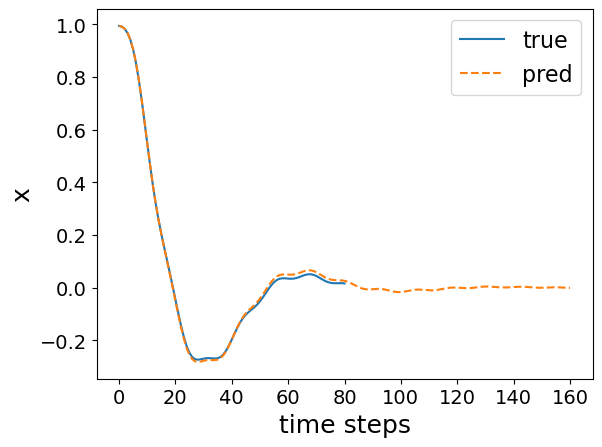

In [98]:
#test
x_pred_mimos = test_traj_plot(mid_mimo, mimo_test, n_step=160, randcomp=True)
#plt.savefig('../Notes/mimo_comp5.png')

In [100]:
np.save('data/mimo_test.npy', mimo_test)
np.save('data/mimo_mid_pred.npy', x_pred_mimos)

In [41]:
x_pred.shape

(201, 16)

In [43]:
x_true = mimo_test[0]
x_true.shape

(81, 16)

In [80]:
v_proj = np.random.rand(16,1)

In [81]:
proj_true = x_true @ v_proj
proj_pred = x_pred @ v_proj

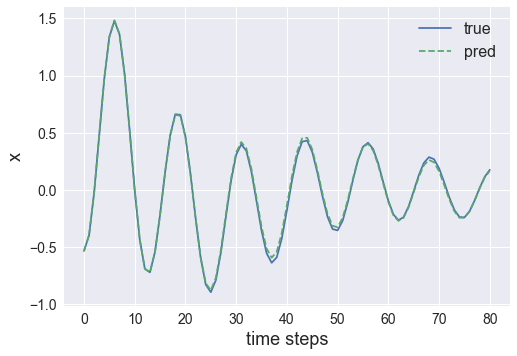

In [82]:
plt.plot(proj_true, label='true')
plt.plot(proj_pred, '--', label='pred')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop={'size': 16})
plt.xlabel('time steps', fontsize=18)
plt.ylabel('x', fontsize=18)
plt.savefig('../Notes/mimo_stable_proj.png')

# Example 1.3: Periodic SISO

In [17]:
filepath = '../matlab/tiny_fb_siso.mat'
xdata, c, k, fdata = load_matlab(filepath)
train_dataset, val_dataset, ts, siso_test = data_loader(xdata, k, one_seq=False, cutoff=20, batch_size=8, val_ratio=0.2, test_ratio=0.1)

force magnitude: 0.975964
dx magnitude: 0.156981


## Explicit model

In [18]:
#build model
x_dim = siso_test.shape[2]
time_steps = ts

# specify hidden dimension
hidden_dim = 2

# build linear model
pex_siso = build_const_exp_model(x_dim, hidden_dim, time_steps, c, k, fsiso)
pex_siso.summary()

Model: "const_exp_rom"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 1)]           0         
_________________________________________________________________
rnn (RNN)                    (None, 20, 1)             8         
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________


In [19]:
train_step, val_step = train_fcns(pex_siso, 1e-2)

In [20]:
_ = train_loop(100, train_step, val_step)

Training acc over epoch: 0.000719
Validation acc: 0.0010
Time taken: 0.04s
Training acc over epoch: 0.000631
Validation acc: 0.0009
Time taken: 0.06s
Training acc over epoch: 0.000631
Validation acc: 0.0009
Time taken: 0.05s
Training acc over epoch: 0.000631
Validation acc: 0.0009
Time taken: 0.05s
Training acc over epoch: 0.000634
Validation acc: 0.0009
Time taken: 0.04s


Test loss of sample 5: 0.020236.


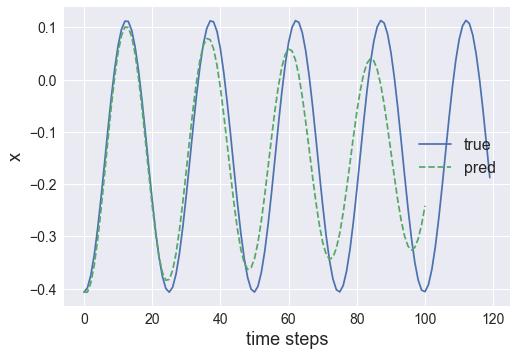

In [25]:
#test
_ = test_traj_plot(pex_siso, siso_test, n_step=100, randsample=True)
#plt.savefig('../Notes/siso_unstable.png')

In [33]:
pex_siso.save_weights('model_weights/pd_siso_exp.h5')

## Mid-point Model

In [29]:
#build model
x_dim = siso_test.shape[2]
time_steps = ts

# specify hidden dimension
hidden_dim = 2

# build linear model
pmd_siso = build_const_mid_model(x_dim, hidden_dim, time_steps, c, k, fsiso, jfsiso)
pmd_siso.summary()

Model: "const_mid_rom"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 20, 1)]           0         
_________________________________________________________________
rnn_1 (RNN)                  (None, 20, 1)             8         
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________


In [30]:
train_step, val_step = train_fcns(pmd_siso, 1e-2)

In [31]:
_ = train_loop(100, train_step, val_step)

Training acc over epoch: 0.009339
Validation acc: 0.0135
Time taken: 0.05s
Training acc over epoch: 0.000001
Validation acc: 0.0000
Time taken: 0.03s
Training acc over epoch: 0.000000
Validation acc: 0.0000
Time taken: 0.03s
Training acc over epoch: 0.000000
Validation acc: 0.0000
Time taken: 0.04s
Training acc over epoch: 0.000000
Validation acc: 0.0000
Time taken: 0.03s


Test loss of sample 4: 0.000000.


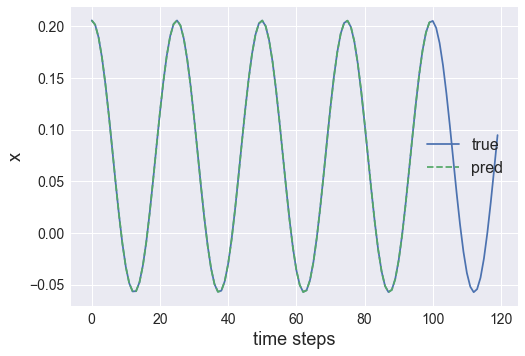

In [32]:
#test
_ = test_traj_plot(pmd_siso, siso_test, n_step=100, randsample=True)
#plt.savefig('../Notes/siso_unstable.png')

In [34]:
pmd_siso.save_weights('model_weights/pd_siso_mid.h5')